In [1]:
#from augment_utils import data_generator
from load_utils import load_image_from_hdf5, byte_string_to_resized_image_array
import numpy as np
import pandas as pd
import h5py
from PIL import Image
import io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load Metadata
metadata = pd.read_csv('metadata.csv')
hdf5_file = 'train-image.hdf5'

# Separate isic_ids based on target class 
malignant_ids = metadata[metadata['target'] == 1]['isic_id'].values
benign_ids = metadata[metadata['target'] == 0]['isic_id'].values

In [3]:
metadata_features = metadata.drop(columns=['isic_id', 'target'])
num_metadata_features = metadata_features.shape[1]
num_metadata_features

22

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Shuffle and split the data
train_frac, val_frac, test_frac = 0.75, 0.15, 0.10

# Split the data into training, validation, and testing sets
train_metadata, temp_metadata = train_test_split(metadata, test_size=(1 - train_frac), random_state=42, shuffle=True, stratify=metadata['target'])
val_metadata, test_metadata = train_test_split(temp_metadata, test_size=(test_frac / (val_frac + test_frac)), random_state=42, shuffle=True, stratify=temp_metadata['target'])

# Check the resulting sizes
print(f"Training set size: {len(train_metadata)}")
print(f"Validation set size: {len(val_metadata)}")
print(f"Test set size: {len(test_metadata)}")

Training set size: 300794
Validation set size: 60159
Test set size: 40106


In [5]:
# Image Generator for benign images
benign_datagen = ImageDataGenerator(rescale=1./255)

# Image Generator for malignant images
malignant_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    rescale=1./255
)

In [6]:
import numpy as np

def data_generator(metadata, benign_ids, malignant_ids, hdf5_file, batch_size=32, 
                                          benign_datagen=None, malignant_datagen=None, 
                                          target_size=(128, 128), malignant_augmentations_per_sample=10, 
                                          num_epochs=10, steps_per_epoch=None):
    """
    A data generator that iterates through the dataset for each epoch, 
    generating multiple augmentations per malignant sample.
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(metadata) // batch_size  # Calculate steps if not provided

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Initialize counters and batch lists
        benign_count = 0
        malignant_count = 0
        step = 0
        
        images, labels, metadata_features = [], [], []
        
        for index, row in metadata.iterrows():
            isic_id = row['isic_id']
            target = row['target']  # Binary label
            meta_features = row.drop(labels=['isic_id', 'target']).values.astype(np.float32)  # Metadata features
            
            # Load image based on isic_id
            image_array = load_image_from_hdf5(isic_id, hdf5_file, target_size=target_size)
            
            # Handle malignant samples with multiple augmentations
            if isic_id in malignant_ids:
                for _ in range(malignant_augmentations_per_sample):
                    augmented_image = malignant_datagen.random_transform(image_array)
                    images.append(augmented_image)
                    labels.append(1)  # Malignant label
                    metadata_features.append(meta_features)
                    malignant_count += 1

                    # Check if batch size is reached
                    if len(images) == batch_size:
                        yield [np.array(images), np.array(metadata_features)], np.array(labels)
                        images, labels, metadata_features = [], [], []  # Reset for next batch
                        step += 1
                        if step >= steps_per_epoch:
                            break
            
            # Handle benign samples without augmentation
            elif isic_id in benign_ids:
                benign_image = benign_datagen.standardize(image_array)
                images.append(benign_image)
                labels.append(0)  # Benign label
                metadata_features.append(meta_features)
                benign_count += 1

                # Check if batch size is reached
                if len(images) == batch_size:
                    yield [np.array(images), np.array(metadata_features)], np.array(labels)
                    images, labels, metadata_features = [], [], []  # Reset for next batch
                    step += 1
                    if step >= steps_per_epoch:
                        break
        
        # Optional: print batch summary
        print(f"Total benign samples processed: {benign_count}, Total malignant samples augmented: {malignant_count}")


In [75]:
# Check the generator
batch_size = 32
num_epochs = 10
steps_per_epoch = 10

train_gen = data_generator(train_metadata.head(150), benign_ids, malignant_ids, hdf5_file, batch_size=batch_size,
                            benign_datagen=benign_datagen, malignant_datagen=malignant_datagen,
                            num_epochs=num_epochs, steps_per_epoch=steps_per_epoch)

# Get a batch from the generator
inputs, targets = next(train_gen)
print(f"Input batch shape: {inputs[0].shape}")
print(f"Metadata batch shape: {inputs[1].shape}")
print(f"Target batch shape: {targets.shape}")

# Check the class distribution
unique, counts = np.unique(targets, return_counts=True)
dict(zip(unique, counts))

Epoch 1/10
Input batch shape: (32, 128, 128, 3)
Metadata batch shape: (32, 22)
Target batch shape: (32,)


{0: 22, 1: 10}

In [8]:
# Get value counts from metadata
num_benign_samples = metadata['target'].value_counts().get(0, 0)  # Number of benign samples
num_malignant_samples = metadata['target'].value_counts().get(1, 0)  # Number of malignant samples

# Calculate effective dataset size for training and validation
train_fraction = 0.75  # Fraction of data for training
val_fraction = 0.15    # Fraction of data for validation
malignant_augmentations_per_sample=10  # Number of augmentations per malignant sample

# Effective dataset size for each split
effective_train_size = (num_benign_samples * train_fraction) + (num_malignant_samples * train_fraction * malignant_augmentations_per_sample)
effective_val_size = (num_benign_samples * val_fraction) + (num_malignant_samples * val_fraction)
effective_test_size = (num_benign_samples * (1 - train_fraction - val_fraction)) + (num_malignant_samples * (1 - train_fraction - val_fraction))

batch_size = 32
num_epochs = 10

# Calculate steps per epoch for training and validation
train_steps = int(np.ceil(effective_train_size / batch_size))
val_steps = int(np.ceil(effective_val_size / batch_size))
test_steps = int(np.ceil(effective_test_size / batch_size))

print("Training steps per epoch:", train_steps)
print("Validation steps per epoch:", val_steps)
print("Test steps per epoch:", test_steps)

Training steps per epoch: 9483
Validation steps per epoch: 1880
Test steps per epoch: 1254


In [9]:
# Create training generator with augmentations
train_generator = data_generator(
    metadata=train_metadata,
    benign_ids=benign_ids,
    malignant_ids=malignant_ids,
    hdf5_file=hdf5_file,
    batch_size=batch_size,
    benign_datagen=benign_datagen,
    malignant_datagen=malignant_datagen,
    malignant_augmentations_per_sample=10,  # Adjust as needed for training
    num_epochs=num_epochs,
    steps_per_epoch=train_steps
)

# Create validation generator without augmentation
val_generator = data_generator(
    metadata=val_metadata,
    benign_ids=benign_ids,
    malignant_ids=malignant_ids,
    hdf5_file=hdf5_file,
    batch_size=batch_size,
    benign_datagen=benign_datagen,
    malignant_datagen=malignant_datagen,
    malignant_augmentations_per_sample=1,  # No augmentation for validation
    num_epochs=num_epochs,
    steps_per_epoch=val_steps
)


In [51]:
from tqdm import tqdm

num_batches = 0
total_batches = train_steps  # Assuming train_generator has a defined length

# Initialize the progress bar
with tqdm(total=total_batches, desc="Processing Batches") as pbar:
    for [images, metadata], labels in train_generator:
        num_batches += 1
        pbar.update(1)  # Update the progress bar

print(f"Total batches processed: {num_batches}")

Processing Batches:   0%|          | 0/9483 [00:00<?, ?it/s]

Epoch 1/1


Processing Batches: 100%|█████████▉| 9482/9483 [39:26<00:00,  4.01it/s]

Total benign samples processed: 300499, Total malignant samples augmented: 2950
Total batches processed: 9482


In [10]:
from tensorflow.keras import layers, models, Input, Model

def create_cnn(input_shape=(128, 128, 3)):
    model = models.Sequential()
    
    # Convolutional layers with Batch Normalization
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten and add dense layer with Batch Normalization
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    
    return model

def create_fcnn(input_shape=(22,)):  # Adjust input_shape based on num_metadata_features
    model = models.Sequential()
    
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    return model

def create_combined_model(image_shape=(128, 128, 3), metadata_shape=(22,)):  # Adjust based on num_metadata_features
    # Create CNN and FCNN models
    cnn_model = create_cnn(image_shape)
    fcnn_model = create_fcnn(metadata_shape)
    
    # Use the models as-is by referencing their outputs directly
    combined = layers.concatenate([cnn_model.output, fcnn_model.output])
    
    # Additional dense layers for combined model with Batch Normalization
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)
    
    # Create the combined model using existing model inputs
    model = Model(inputs=[cnn_model.input, fcnn_model.input], outputs=output)
    
    return model


In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'target' is the label column with 0s and 1s
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_metadata['target'].values)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [12]:
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import numpy as np

def partial_auc_80_tpr(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32).numpy()
    y_pred = tf.cast(y_pred, tf.float32).numpy()
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    mask = tpr >= 0.8
    fpr = fpr[mask]
    tpr = tpr[mask]
    
    if len(fpr) < 2:
        return tf.constant(0.0)
    
    partial_auc = auc(fpr, tpr)
    return tf.constant(partial_auc, dtype=tf.float32)

@tf.function
def partial_auc_80_tpr_metric(y_true, y_pred):
    return tf.py_function(partial_auc_80_tpr, (y_true, y_pred), tf.float32)

In [13]:
# clear the session
tf.keras.backend.clear_session()

# Create the combined model
model = create_combined_model(image_shape=(128, 128, 3), metadata_shape=(num_metadata_features,))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['conv2d_input[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

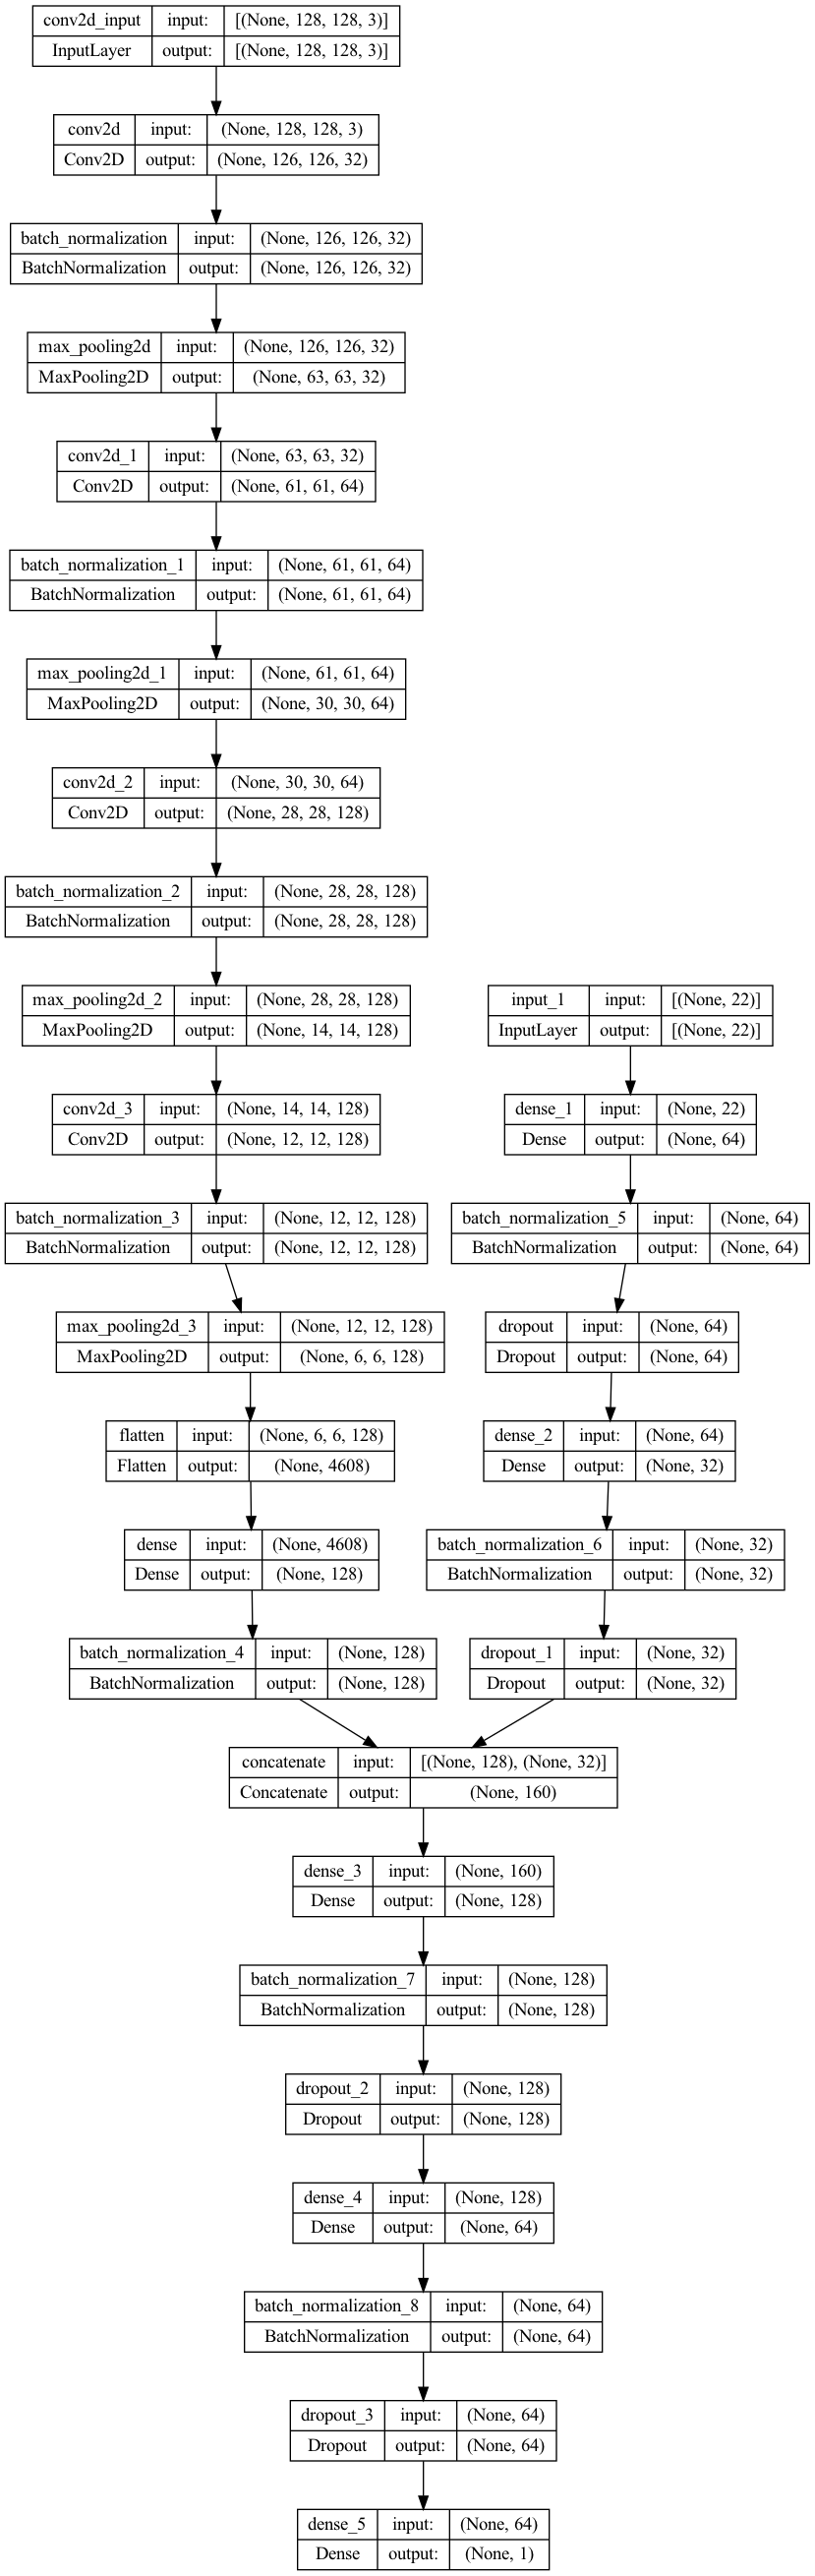

In [15]:
# plot the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='plots/model_plot_v2.png', show_shapes=True, show_layer_names=True)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping based on custom pAUC metric
early_stopping = EarlyStopping(
    monitor='val_partial_auc_80_tpr_metric',  # This should match the metric name used during model compilation
    patience=5,                               # Number of epochs to wait before stopping if no improvement
    mode='max',                                # Stop when the monitored metric has stopped increasing
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoints/epoch_{epoch:02d}.h5',  # Save each epoch with the epoch number in the filename
    save_weights_only=False,  # Save the entire model (architecture + weights + optimizer state)
    save_freq='epoch',  # Save at the end of every epoch
    verbose=0  # Print a message when saving
)


In [17]:
from tensorflow.keras.callbacks import Callback

class PartialAUC80Callback(Callback):
    def __init__(self, val_gen, val_steps):
        super(PartialAUC80Callback, self).__init__()
        self.val_gen = val_gen
        self.val_steps = val_steps
        self.best_auc = 0.0
        self.patience_counter = 0
        self.patience = 5  # Adjust early stopping patience here

    def on_epoch_end(self, epoch, logs=None):
        # Collect predictions and true labels from the validation generator
        y_true, y_pred = [], []
        for step, (inputs, labels) in enumerate(self.val_gen):
            images, metadata = inputs
            predictions = self.model.predict([images, metadata], verbose=0)
            y_true.extend(labels)
            y_pred.extend(predictions.ravel())  # Flatten predictions

            if step >= self.val_steps:
                break

        # Convert to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate partial AUC for TPR >= 0.8
        epoch_auc = partial_auc_80_tpr(y_true, y_pred).numpy()
        print(f"\nEpoch {epoch + 1} - Validation pAUC above 80% TPR: {epoch_auc:.4f}")

        # Update logs with the custom metric
        logs["val_partial_auc_80_tpr_metric"] = epoch_auc

        # Early stopping check
        if epoch_auc > self.best_auc:
            self.best_auc = epoch_auc
            self.patience_counter = 0  # Reset patience
            self.model.save_weights("best_model_weights.h5")  # Save best model
        else:
            self.patience_counter += 1

        if self.patience_counter >= self.patience:
            print("Early stopping triggered. Restoring best model weights.")
            self.model.stop_training = True
            self.model.load_weights("best_model_weights.h5")

In [18]:
# Instantiate the callback with validation generator and steps
partial_auc_callback = PartialAUC80Callback(val_gen=val_generator, val_steps=val_steps)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=num_epochs,  # Maximum epochs, early stopping will handle stopping
    validation_data=val_generator,
    validation_steps=val_steps,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
Epoch 1/10


2024-11-01 21:00:32.361883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-01 21:00:32.370429: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9482/9483 [============================>.] - ETA: 0s - loss: 0.5238 - accuracy: 0.8001Total benign samples processed: 300499, Total malignant samples augmented: 2950
Epoch 2/10
9483/9483 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.8001Epoch 1/10


2024-11-01 21:58:43.935818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Total benign samples processed: 60100, Total malignant samples augmented: 59
Epoch 2/10
9483/9483 [==============================] - 3994s 421ms/step - loss: 0.5238 - accuracy: 0.8001 - val_loss: 0.2516 - val_accuracy: 0.9995
Epoch 2/10
9481/9483 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.9441Total benign samples processed: 300499, Total malignant samples augmented: 2950
Epoch 3/10
9483/9483 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9441Total benign samples processed: 60100, Total malignant samples augmented: 59
Epoch 3/10
9483/9483 [==============================] - 3993s 421ms/step - loss: 0.2446 - accuracy: 0.9441 - val_loss: 0.1269 - val_accuracy: 0.9987
Epoch 3/10
9479/9483 [============================>.] - ETA: 1s - loss: 0.1213 - accuracy: 0.9750Total benign samples processed: 300499, Total malignant samples augmented: 2950
Epoch 4/10
9483/9483 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9750

In [21]:
# get predictions
# Create validation generator without augmentation
val_generator = data_generator(
    metadata=val_metadata,
    benign_ids=benign_ids,
    malignant_ids=malignant_ids,
    hdf5_file=hdf5_file,
    batch_size=batch_size,
    benign_datagen=benign_datagen,
    malignant_datagen=malignant_datagen,
    malignant_augmentations_per_sample=10,  # No augmentation for validation
    num_epochs=1,
    steps_per_epoch=val_steps
)

y_true, y_pred = [], []
for step, (inputs, labels) in enumerate(val_generator):
    images, metadata = inputs
    predictions = model.predict([images, metadata], verbose=0)
    y_true.extend(labels)
    y_pred.extend(predictions.ravel())  # Flatten predictions

    if step >= val_steps:
        break

Epoch 1/1
Total benign samples processed: 59580, Total malignant samples augmented: 580


Validation AUC: 0.9999


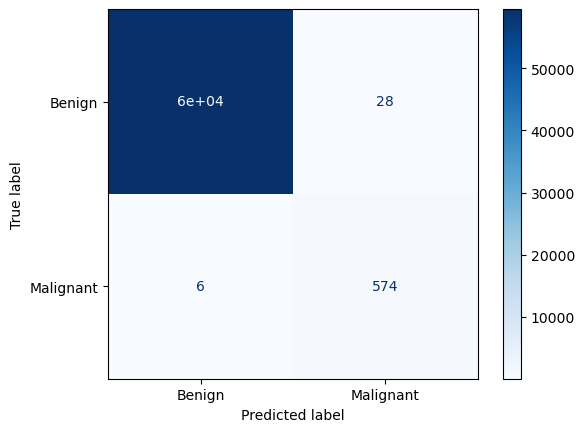

In [23]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate AUC
auc = roc_auc_score(y_true, y_pred)
print(f"Validation AUC: {auc:.4f}")

# Calculate partial AUC for TPR >= 0.8
#partial_auc = partial_auc_80_tpr(y_true, y_pred).numpy()
#print(f"Validation pAUC above 80% TPR: {partial_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')

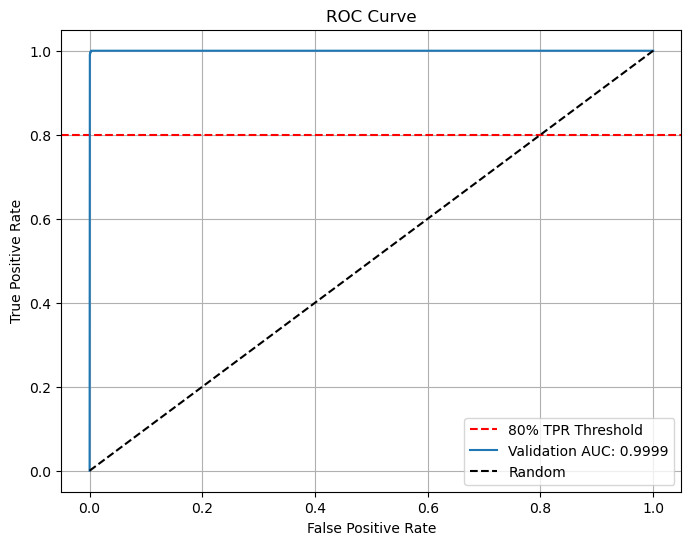

In [24]:
# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.axhline(0.8, color='r', linestyle='--', label="80% TPR Threshold")
plt.plot(fpr, tpr, label=f"Validation AUC: {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


Epoch 1/1


2024-11-03 14:31:05.197409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1254/1254 [==============================] - 332s 265ms/step - loss: 0.0315 - accuracy: 0.9995
Test Loss: 0.0315
Test Accuracy: 0.9995
Epoch 1/1
Total benign samples processed: 40067, Total malignant samples augmented: 39
Test AUC: 0.9747


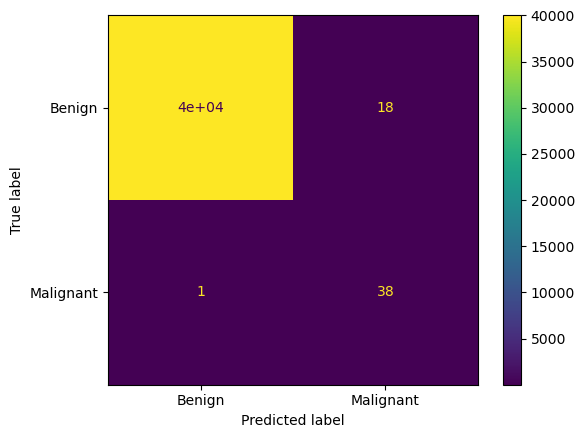

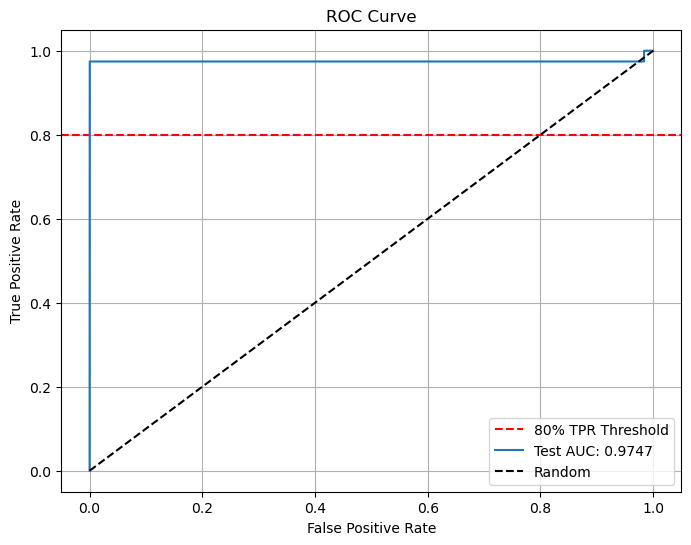

In [25]:
# Evaluate the model on the test set
test_generator = data_generator(
    metadata=test_metadata,
    benign_ids=benign_ids,
    malignant_ids=malignant_ids,
    hdf5_file=hdf5_file,
    batch_size=batch_size,
    benign_datagen=benign_datagen,
    malignant_datagen=malignant_datagen,
    malignant_augmentations_per_sample=1,  # No augmentation for validation
    num_epochs=1,
    steps_per_epoch=test_steps
)

# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)

# Print test results
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# get predictions
# Create validation generator without augmentation
test_generator = data_generator(
    metadata=test_metadata,
    benign_ids=benign_ids,
    malignant_ids=malignant_ids,
    hdf5_file=hdf5_file,
    batch_size=batch_size,
    benign_datagen=benign_datagen,
    malignant_datagen=malignant_datagen,
    malignant_augmentations_per_sample=1    ,  # No augmentation for validation
    num_epochs=1,
    steps_per_epoch=test_steps
)

y_true, y_pred = [], []
for step, (inputs, labels) in enumerate(test_generator):
    images, metadata = inputs
    predictions = model.predict([images, metadata], verbose=0)
    y_true.extend(labels)
    y_pred.extend(predictions.ravel())  # Flatten predictions

    if step >= test_steps:
        break

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate AUC
auc = roc_auc_score(y_true, y_pred)
print(f"Test AUC: {auc:.4f}")

# Calculate partial AUC for TPR >= 0.8
#partial_auc = partial_auc_80_tpr(y_true, y_pred).numpy()
#print(f"Test pAUC above 80% TPR: {partial_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='viridis')

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.axhline(0.8, color='r', linestyle='--', label="80% TPR Threshold")
plt.plot(fpr, tpr, label=f"Test AUC: {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()    
plt.grid()
plt.show()

In [26]:
def custom_metric_raw(y_hat, y_true):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Calculate the custom metric
custom_metric = custom_metric_raw(y_pred, y_true)
print(f"Test Custom Metric: {custom_metric:.4f}")

Test Custom Metric: 0.1747


In [27]:
# Save the model
model.save('skin_cancer_model_V2.h5')

In [29]:
len(y_pred) == len(y_true)

True

In [32]:
# Tune the model using Keras Tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the hypermodel
def build_hypermodel(hp):
    # Create CNN and FCNN models
    model = create_combined_model(image_shape=(128, 128, 3), metadata_shape=(num_metadata_features,))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', partial_auc_80_tpr_metric]
    )
    
    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials
    executions_per_trial=1,  # Set the number of executions per trial
    directory='keras_tuner_dir',  # Path to the output directory
    project_name='skin_cancer_tuner'  # Name of the project
)

# Search for the best hyperparameters
tuner.search(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_steps
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 1 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 01s
